In [2]:
!pip install keras_maskrcnn

     |████████████████████████████████| 61kB 4.2MB/s 
  Created wheel for keras-maskrcnn: filename=keras_maskrcnn-0.2.2-cp36-none-any.whl size=41692 sha256=72b1bf9991e1b7c82c6600ade5af8c64348cb8c5973693630d4ff9c0c4bb2619
  Stored in directory: /root/.cache/pip/wheels/0b/03/0e/652a317641021f3450b92b69567e64cc54597d71e809426be8
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=156761 sha256=691f1a5ecaf7412ca91543d05a5e2ecae9fee4ec1cd3434e04093f554e9faa96
  Stored in directory: /root/.cache/pip/wheels/d9/a5/98/87f8ed08913b184bb625dde1c1277a4dfe969c77b377abde69
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20485 sha256=99bb15fb3cb79f9731ba2e7ce2c507b2f78882af7631a922019b0471e11d7cd0
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-maskrcnn keras-retinanet keras-resnet


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras
import keras_maskrcnn
import keras_retinanet 

# import keras_retinanet
from keras_maskrcnn import models
from keras_maskrcnn.utils.visualization import draw_mask
from keras_retinanet.utils.visualization import draw_box, draw_caption, draw_annotations
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import json

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# adjust this to point to your downloaded/trained model
model_path = os.path.join('/content/drive/My Drive/Insight/Project/MAsk-RCNN', 'resnet50_modanet.h5')

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
#print(model.summary())

# load label to names mapping for visualization purposes
labels_to_names = {1: 'bag', 2: 'belt', 3: 'boots', 4: 'footwear', 5: 'outer', 6: 'dress', 7: 'sunglasses', 8: 'pants', 9: 'top', 10: 'shorts', 11: 'skirt', 12: 'headwear', 13: 'scarf/tie'}








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
box_ind is deprecated, use box_indices instead







/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:335: UserWarning: Output "filtered_detections" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "filtered_detections" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:335: UserWarning: Output "mask_submodel" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "mask_submodel" during training.
  sample_weight_mode=sample_weight_mode)
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWar

processing time:  11.872753858566284


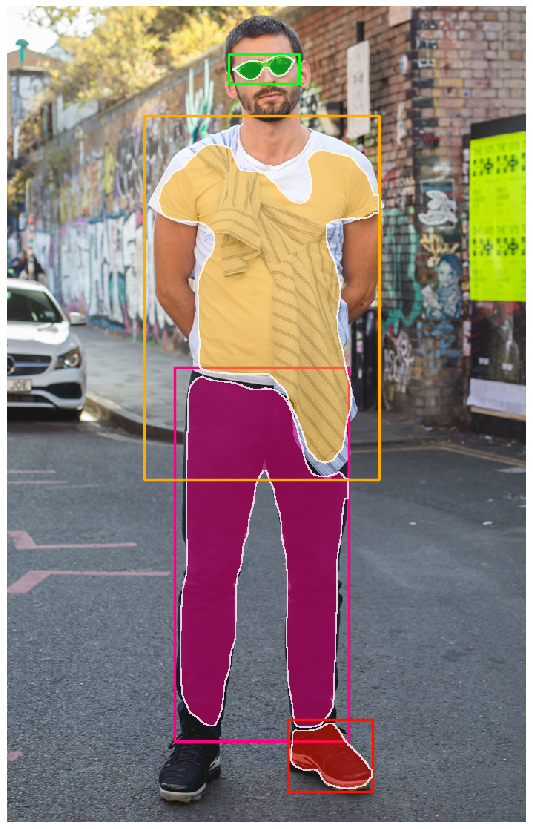

In [11]:
# load image
image = read_image_bgr('/content/drive/My Drive/Insight/Project/MAsk-RCNN/2019hannahsept27.jpg')

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = preprocess_image(image)
image, scale = resize_image(image)

# process image
start = time.time()
outputs = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

boxes  = outputs[-4][0]
scores = outputs[-3][0]
labels = outputs[-2][0]
masks  = outputs[-1][0]

# correct for image scale
boxes /= scale

# visualize detections
for box, score, label, mask in zip(boxes, scores, labels, masks):
    if score < 0.5:
        break

    color = label_color(label)
    
    b = box.astype(int)
    draw_box(draw, b, color=color)
    
    mask = mask[:, :, label]
    draw_mask(draw, b, mask, color=label_color(label))
    
    caption = "{} {:.3f}".format(labels_to_names[label], score)
    #draw_caption(draw, b, caption)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()